# Day 6 – Ridge and LASSO Regularization

Goal: Visualize and interpret how Ridge and LASSO regularization techniques impact feature weights in a mission success prediction model.



## Load & Prepare Data

In [9]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

# Load and Preprocess Data 
df = pd.read_csv("/Users/amrithaa/Downloads/12DayDataSeries/notebooks/data/encoded_data.csv")
X = df.drop(columns=['mission_id', 'mission_success_score', 'mission_outcome'])
y = df['mission_success_score']

# Convert boolean features to integers
for col in X.select_dtypes(include=['bool']).columns:
    X[col] = X[col].astype(int)


## Scale the features 

Regularization techniques are sensitive to the scale of the features. The penalty term (
lambda) is applied to the coefficients, and if features have vastly different scales (e.g., one feature from 0-1, another from 100-10,000), the model will penalize the feature on the larger scale more heavily, simply because its coefficient will naturally be smaller.

To ensure that the regularization is applied fairly, we must scale our features so they are on a comparable scale. StandardScaler is a common choice; it transforms the data to have a mean of 0 and a standard deviation of 1.

Recall feature engineering from day 3?

In [10]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use X_scaled in the next steps

## Generate Coefficients for Range of Penalty

We'll train many Ridge and LASSO models, each with a different penalty strength, to observe how the coefficients change.

alphas: This is a range of values for the regularization parameter, often denoted by lambda (
lambda). We use np.logspace(-4, 2, 100) to create 100 values from 10^−4 to 10^2. A logarithmic scale allows us to see the effect of both very small and very large penalties.

The Loop: For each alpha value, we initialize a new Ridge or LASSO model, fit it to our scaled data (X_scaled), and store the resulting coefficients.

max_iter=10000: For LASSO, the optimization algorithm can sometimes struggle to converge, so we increase the maximum number of iterations to ensure it finds a solution.

In [11]:
alphas = np.logspace(-4, 2, 100)

ridge_coefs = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_scaled, y)
    ridge_coefs.append(ridge.coef_)

lasso_coefs = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_scaled, y)
    lasso_coefs.append(lasso.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

## Visualize the Results

- The plots we generate are called regularization paths or coefficient paths. They are the heart of this analysis.

- X-axis: The log of the regularization strength (log_10(lambda)). As we move from left to right, the penalty for large coefficients increases.
- Y-axis: The value of the coefficient for each feature.

Each Line: Represents a single feature in our model. Its path shows how its importance (its coefficient value) changes as the model is penalized more heavily.

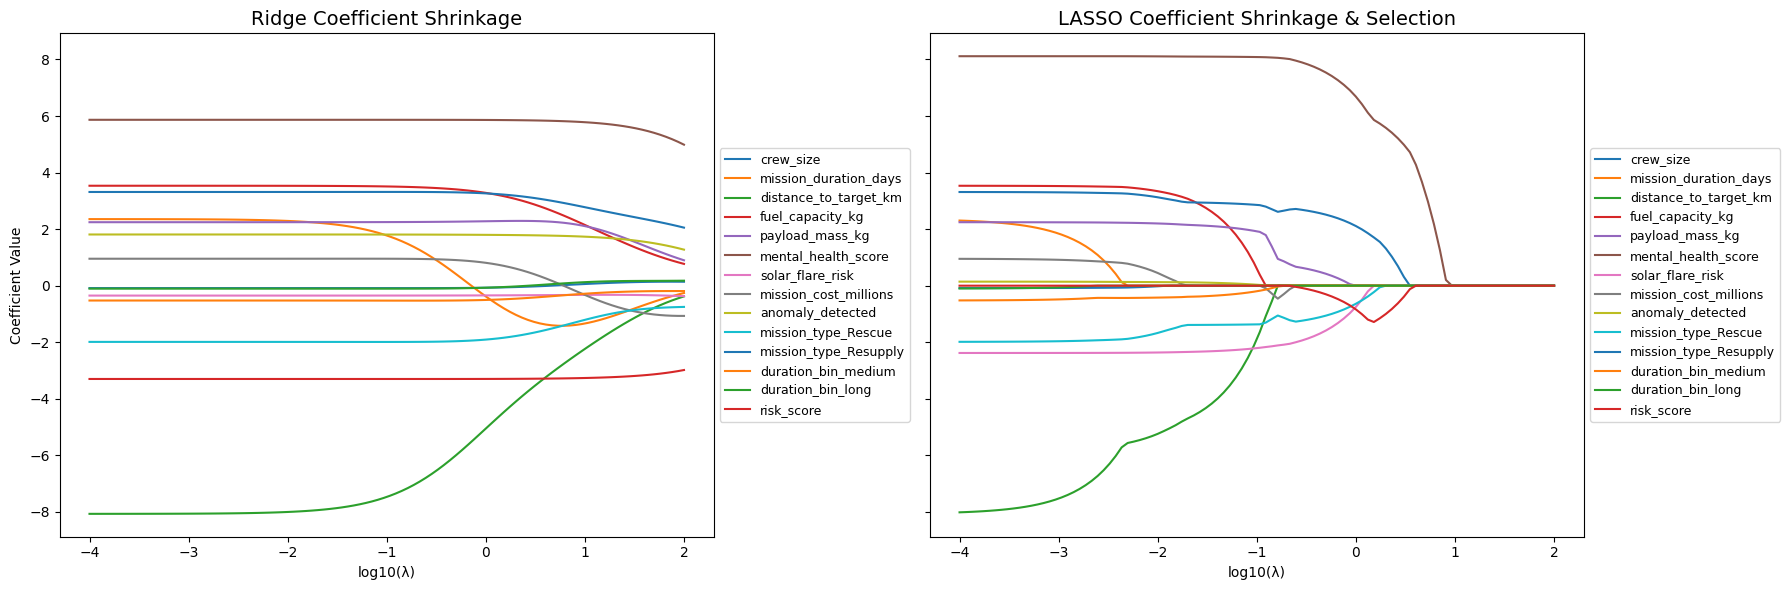

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Ridge
for i in range(len(X.columns)):
    axes[0].plot(np.log10(alphas), ridge_coefs[:, i], label=X.columns[i])
axes[0].set_title("Ridge Coefficient Shrinkage", fontsize=14)
axes[0].set_xlabel("log10(\u03bb)")
axes[0].set_ylabel("Coefficient Value")
axes[0].legend(fontsize=9, loc='center left', bbox_to_anchor=(1, 0.5))

# LASSO
for i in range(len(X.columns)):
    axes[1].plot(np.log10(alphas), lasso_coefs[:, i], label=X.columns[i])
axes[1].set_title("LASSO Coefficient Shrinkage & Selection", fontsize=14)
axes[1].set_xlabel("log10(\u03bb)")
axes[1].legend(fontsize=9, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Let's break down what these visualizations tell us about our mission success model.

#### **Ridge Regression (L2 Penalty): The Gentle Shrinker**
The Ridge plot shows that as the penalty ($\lambda$) increases, all coefficients are pushed towards zero in a smooth, continuous way.

* **Why?** The Ridge penalty is the "sum of squared coefficients" ($\lambda \sum \beta_j^2$). Because the penalty is squared, a very large coefficient is penalized disproportionately more than a small one. This forces the model to distribute the weight more evenly among all features rather than relying heavily on just a few. It will never make a coefficient *exactly* zero unless the feature provides absolutely no information.
* **For Mission Success:** Ridge is useful when you believe that **most of your features are probably relevant** to mission success. It prevents any single factor (like `solar_flare_risk`) from dominating the model, especially if it's correlated with other features. It tames the model's complexity while retaining all variables.

---

#### **LASSO Regression (L1 Penalty): The Feature Selector**
The LASSO plot is dramatically different. As $\lambda$ increases, many of the coefficient paths drop sharply and hit exactly zero.

* **Why?** The LASSO penalty is the "sum of absolute values of coefficients" ($\lambda \sum |\beta_j|$). This type of penalty can result in solutions where some coefficients ($\beta_j$) are set precisely to zero. This means LASSO is performing **automatic feature selection**.
* **For Mission Success:** This is incredibly useful for creating a simpler, more interpretable model. LASSO tells us which features are the most critical predictors of success. The features whose lines remain non-zero for the longest time are the most influential. For example, if `mental_health_score` and `crew_skill_level` survive high penalties, LASSO is telling us to focus our resources on monitoring and improving those areas. Features that drop to zero quickly are considered noise or redundant by the model.

---

### **Conclusion & Next Steps ✅**

* **Ridge** is a great choice when you have many features that you believe are all somewhat important and may be correlated with each other. It provides a stable model by reducing coefficient variance.
* **LASSO** is ideal when you want to simplify your model and identify a smaller subset of the most impactful features. It provides a more parsimonious and often more interpretable result.
